In [3]:
import math
import random
import copy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [5]:
def read_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    num_points = len(lines)
    dim_points = 28 * 28
    data = np.empty((num_points, dim_points))
    labels = np.empty(num_points)
    
    for ind, line in enumerate(lines):
        num = line.split(',')
        labels[ind] = int(num[0])
        data[ind] = [ int(x) for x in num[1:] ]
        
    return (data, labels)

train_data, train_labels = read_data("sample_train.csv")
test_data, test_labels = read_data("sample_test.csv")
print(train_data.shape, test_data.shape)
print(train_labels.shape, test_labels.shape)

(6000, 784) (1000, 784)
(6000,) (1000,)


In [6]:
class DQN(nn.Module):
    def __init__(self, in_features):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=2)

    def forward(self, t):
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.fc3(t)
        return t

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

    def __len__(self):
        return len(self.memory)

class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

In [7]:
class Net(nn.Module):
    def __init__(self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x))

def train(model, optimizer, X, criterion=nn.NLLLoss()):
    epochs = 1
    batch_size = 64
    for e in range(epochs):
        running_loss = 0
        num_batches = 0
        order = np.copy(X)
        np.random.shuffle(order)
        i = 0
        while i < len(X):
            j = min(i + batch_size, len(X))
            images = train_data[order[i:j], :]
            labels = torch.Tensor(train_labels[order[i:j]]).long()
            optimizer.zero_grad()
            output = model(torch.from_numpy(images).float())
            loss = F.nll_loss(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_batches += 1
            i += batch_size

def predict(model):
    with torch.no_grad():
        output = model(torch.from_numpy(test_data).float())
    softmax = torch.exp(torch.Tensor(output))
    prob = softmax.numpy()
    predictions = np.argmax(prob, axis=1)
    return accuracy_score(test_labels, predictions)

In [8]:
batch_size = 64
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.0001
memory_size = 1000
num_episodes = 5
state_len = 10 + 784
budget = 1000
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
memory = ReplayMemory(memory_size)
dqnet = DQN(state_len)
target_dqnet = DQN(state_len)
target_dqnet.load_state_dict(dqnet.state_dict())
dqnet_optimizer = optim.Adam(dqnet.parameters(), lr=5e-3)
num_actions = 2
current_step = 0
target_update = 8

In [9]:
def dqn_train(model, target_model, optimizer, mini_batch):
    criterion = nn.MSELoss()
    optimizer.zero_grad()
    states = np.array([exp[0] for exp in mini_batch])
    actions = torch.Tensor([[exp[1]] for exp in mini_batch]).long()
    rewards = torch.Tensor([exp[2] for exp in mini_batch])
    next_states = torch.Tensor([exp[3] for exp in mini_batch])
    output = model(torch.from_numpy(states).float())
    predicted = torch.gather(output, 1, actions).squeeze()
    with torch.no_grad():
        labels_next = target_model(next_states).detach().max(1).values
    labels = rewards + gamma * labels_next
    loss = criterion(predicted, labels)
    loss.backward()
    optimizer.step()

def select_action(state, model, current_step):
    eps = strategy.get_exploration_rate(current_step)
    if random.random() < eps:
        return random.randrange(num_actions)
    else:
        with torch.no_grad():
            a = model(torch.from_numpy(state).float()).argmax().item()
        return a

In [10]:
order = list(range(0, train_data.shape[0]))
plots = []
X_labelled = []
random.shuffle(order)
for _ in range(num_episodes):
    memory.memory.clear()
    plot_data = []
    i = 0
    print('Episode {} started'.format(_ + 1))
    model = Net(28 * 28)
    model_optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
    prev_acc = 0
    for j in range(train_data.shape[0]):
        print('episode ', _, ', id ', j, ', label ', train_labels[order[j]])
        sample = train_data[order[j]]
        part1 = np.copy(sample)
        with torch.no_grad():
            part2 = model(torch.from_numpy(sample).float()).detach().numpy()
            part2 = np.exp(part2)
            part2 = part2 / np.sum(part2)
        state = np.concatenate((part1, part2))
        
        a = select_action(state, dqnet, current_step)
        current_step += 1
        queried = False
        if a == 1:
            queried = True
            X_labelled.append(order[j])
            i += 1
            if i % 16 == 0:
                train(model, model_optimizer, X_labelled)
                plot_data.append([len(X_labelled), acc])
        if queried:
            acc = predict(model)
            r = acc - prev_acc
            prev_acc = acc
        else:
            r = 0
        if i == budget:
            print('Budget over')
            X_labelled = []
            random.shuffle(order)
            sample = train_data[order[0]]
            part1 = np.copy(sample)
            with torch.no_grad():
                part2 = model(torch.from_numpy(sample).float()).detach().numpy()
                part2 = np.exp(part2)
                part2 = part2 / np.sum(part2)
            new_state = np.concatenate((part1, part2))
            memory.push(state, a, r, new_state)
            break
        
        sample = train_data[order[j + 1]]
        part1 = np.copy(sample)
        with torch.no_grad():
            part2 = model(torch.from_numpy(sample).float()).detach().numpy()
            part2 = np.exp(part2)
            part2 = part2 / np.sum(part2)
        new_state = np.concatenate((part1, part2))
        memory.push(state, a, r, new_state)
        if memory.can_provide_sample(batch_size):
            mini_batch = memory.sample(batch_size)
            dqn_train(dqnet, target_dqnet, dqnet_optimizer, mini_batch)
        if j % target_update == 0:
            target_dqnet.load_state_dict(dqnet.state_dict())
    plots.append(plot_data)
    print('final acc', predict(model))
    if i < budget:
        print('Budget left', len(X_labelled))
        X_labelled = []
        random.shuffle(order)

Episode 1 started
episode  0 , id  0 , label  8.0
episode  0 , id  1 , label  5.0
episode  0 , id  2 , label  7.0
episode  0 , id  3 , label  5.0
episode  0 , id  4 , label  3.0
episode  0 , id  5 , label  0.0
episode  0 , id  6 , label  3.0
episode  0 , id  7 , label  0.0
episode  0 , id  8 , label  7.0
episode  0 , id  9 , label  2.0
episode  0 , id  10 , label  9.0
episode  0 , id  11 , label  2.0
episode  0 , id  12 , label  5.0
episode  0 , id  13 , label  1.0
episode  0 , id  14 , label  9.0
episode  0 , id  15 , label  0.0
episode  0 , id  16 , label  5.0
episode  0 , id  17 , label  5.0
episode  0 , id  18 , label  8.0
episode  0 , id  19 , label  0.0
episode  0 , id  20 , label  7.0
episode  0 , id  21 , label  6.0
episode  0 , id  22 , label  0.0
episode  0 , id  23 , label  6.0
episode  0 , id  24 , label  8.0
episode  0 , id  25 , label  0.0
episode  0 , id  26 , label  2.0
episode  0 , id  27 , label  4.0
episode  0 , id  28 , label  5.0
episode  0 , id  29 , label  0.0
ep

/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


episode  0 , id  68 , label  0.0
episode  0 , id  69 , label  9.0
episode  0 , id  70 , label  8.0
episode  0 , id  71 , label  4.0
episode  0 , id  72 , label  7.0
episode  0 , id  73 , label  5.0
episode  0 , id  74 , label  4.0
episode  0 , id  75 , label  4.0
episode  0 , id  76 , label  2.0
episode  0 , id  77 , label  8.0
episode  0 , id  78 , label  4.0
episode  0 , id  79 , label  7.0
episode  0 , id  80 , label  4.0
episode  0 , id  81 , label  9.0
episode  0 , id  82 , label  1.0
episode  0 , id  83 , label  0.0
episode  0 , id  84 , label  0.0
episode  0 , id  85 , label  1.0
episode  0 , id  86 , label  8.0
episode  0 , id  87 , label  6.0
episode  0 , id  88 , label  5.0
episode  0 , id  89 , label  4.0
episode  0 , id  90 , label  8.0
episode  0 , id  91 , label  5.0
episode  0 , id  92 , label  9.0
episode  0 , id  93 , label  0.0
episode  0 , id  94 , label  8.0
episode  0 , id  95 , label  5.0
episode  0 , id  96 , label  4.0
episode  0 , id  97 , label  2.0
episode  0

episode  0 , id  317 , label  6.0
episode  0 , id  318 , label  0.0
episode  0 , id  319 , label  5.0
episode  0 , id  320 , label  3.0
episode  0 , id  321 , label  2.0
episode  0 , id  322 , label  1.0
episode  0 , id  323 , label  9.0
episode  0 , id  324 , label  6.0
episode  0 , id  325 , label  0.0
episode  0 , id  326 , label  3.0
episode  0 , id  327 , label  0.0
episode  0 , id  328 , label  4.0
episode  0 , id  329 , label  6.0
episode  0 , id  330 , label  6.0
episode  0 , id  331 , label  0.0
episode  0 , id  332 , label  0.0
episode  0 , id  333 , label  1.0
episode  0 , id  334 , label  3.0
episode  0 , id  335 , label  6.0
episode  0 , id  336 , label  2.0
episode  0 , id  337 , label  6.0
episode  0 , id  338 , label  4.0
episode  0 , id  339 , label  1.0
episode  0 , id  340 , label  9.0
episode  0 , id  341 , label  5.0
episode  0 , id  342 , label  4.0
episode  0 , id  343 , label  4.0
episode  0 , id  344 , label  3.0
episode  0 , id  345 , label  8.0
episode  0 , i

episode  0 , id  567 , label  7.0
episode  0 , id  568 , label  0.0
episode  0 , id  569 , label  0.0
episode  0 , id  570 , label  7.0
episode  0 , id  571 , label  8.0
episode  0 , id  572 , label  1.0
episode  0 , id  573 , label  4.0
episode  0 , id  574 , label  0.0
episode  0 , id  575 , label  4.0
episode  0 , id  576 , label  0.0
episode  0 , id  577 , label  3.0
episode  0 , id  578 , label  7.0
episode  0 , id  579 , label  1.0
episode  0 , id  580 , label  5.0
episode  0 , id  581 , label  7.0
episode  0 , id  582 , label  4.0
episode  0 , id  583 , label  5.0
episode  0 , id  584 , label  5.0
episode  0 , id  585 , label  1.0
episode  0 , id  586 , label  1.0
episode  0 , id  587 , label  1.0
episode  0 , id  588 , label  2.0
episode  0 , id  589 , label  9.0
episode  0 , id  590 , label  8.0
episode  0 , id  591 , label  1.0
episode  0 , id  592 , label  4.0
episode  0 , id  593 , label  4.0
episode  0 , id  594 , label  0.0
episode  0 , id  595 , label  1.0
episode  0 , i

episode  0 , id  820 , label  2.0
episode  0 , id  821 , label  4.0
episode  0 , id  822 , label  0.0
episode  0 , id  823 , label  3.0
episode  0 , id  824 , label  8.0
episode  0 , id  825 , label  6.0
episode  0 , id  826 , label  7.0
episode  0 , id  827 , label  7.0
episode  0 , id  828 , label  1.0
episode  0 , id  829 , label  6.0
episode  0 , id  830 , label  5.0
episode  0 , id  831 , label  1.0
episode  0 , id  832 , label  7.0
episode  0 , id  833 , label  8.0
episode  0 , id  834 , label  0.0
episode  0 , id  835 , label  4.0
episode  0 , id  836 , label  5.0
episode  0 , id  837 , label  4.0
episode  0 , id  838 , label  1.0
episode  0 , id  839 , label  1.0
episode  0 , id  840 , label  0.0
episode  0 , id  841 , label  9.0
episode  0 , id  842 , label  5.0
episode  0 , id  843 , label  9.0
episode  0 , id  844 , label  5.0
episode  0 , id  845 , label  1.0
episode  0 , id  846 , label  7.0
episode  0 , id  847 , label  7.0
episode  0 , id  848 , label  2.0
episode  0 , i

episode  0 , id  1067 , label  8.0
episode  0 , id  1068 , label  7.0
episode  0 , id  1069 , label  9.0
episode  0 , id  1070 , label  5.0
episode  0 , id  1071 , label  8.0
episode  0 , id  1072 , label  8.0
episode  0 , id  1073 , label  9.0
episode  0 , id  1074 , label  5.0
episode  0 , id  1075 , label  4.0
episode  0 , id  1076 , label  4.0
episode  0 , id  1077 , label  8.0
episode  0 , id  1078 , label  5.0
episode  0 , id  1079 , label  5.0
episode  0 , id  1080 , label  3.0
episode  0 , id  1081 , label  7.0
episode  0 , id  1082 , label  0.0
episode  0 , id  1083 , label  4.0
episode  0 , id  1084 , label  4.0
episode  0 , id  1085 , label  5.0
episode  0 , id  1086 , label  7.0
episode  0 , id  1087 , label  9.0
episode  0 , id  1088 , label  7.0
episode  0 , id  1089 , label  9.0
episode  0 , id  1090 , label  7.0
episode  0 , id  1091 , label  6.0
episode  0 , id  1092 , label  6.0
episode  0 , id  1093 , label  9.0
episode  0 , id  1094 , label  7.0
episode  0 , id  109

episode  0 , id  1311 , label  4.0
episode  0 , id  1312 , label  0.0
episode  0 , id  1313 , label  9.0
episode  0 , id  1314 , label  0.0
episode  0 , id  1315 , label  0.0
episode  0 , id  1316 , label  1.0
episode  0 , id  1317 , label  1.0
episode  0 , id  1318 , label  6.0
episode  0 , id  1319 , label  6.0
episode  0 , id  1320 , label  3.0
episode  0 , id  1321 , label  1.0
episode  0 , id  1322 , label  9.0
episode  0 , id  1323 , label  1.0
episode  0 , id  1324 , label  5.0
episode  0 , id  1325 , label  3.0
episode  0 , id  1326 , label  9.0
episode  0 , id  1327 , label  9.0
episode  0 , id  1328 , label  3.0
episode  0 , id  1329 , label  9.0
episode  0 , id  1330 , label  6.0
episode  0 , id  1331 , label  6.0
episode  0 , id  1332 , label  7.0
episode  0 , id  1333 , label  6.0
episode  0 , id  1334 , label  3.0
episode  0 , id  1335 , label  3.0
episode  0 , id  1336 , label  2.0
episode  0 , id  1337 , label  6.0
episode  0 , id  1338 , label  5.0
episode  0 , id  133

episode  0 , id  1551 , label  5.0
episode  0 , id  1552 , label  7.0
episode  0 , id  1553 , label  5.0
episode  0 , id  1554 , label  4.0
episode  0 , id  1555 , label  0.0
episode  0 , id  1556 , label  5.0
episode  0 , id  1557 , label  7.0
episode  0 , id  1558 , label  2.0
episode  0 , id  1559 , label  7.0
episode  0 , id  1560 , label  1.0
episode  0 , id  1561 , label  2.0
episode  0 , id  1562 , label  3.0
episode  0 , id  1563 , label  0.0
episode  0 , id  1564 , label  5.0
episode  0 , id  1565 , label  5.0
episode  0 , id  1566 , label  5.0
episode  0 , id  1567 , label  0.0
episode  0 , id  1568 , label  2.0
episode  0 , id  1569 , label  5.0
episode  0 , id  1570 , label  6.0
episode  0 , id  1571 , label  4.0
episode  0 , id  1572 , label  7.0
episode  0 , id  1573 , label  4.0
episode  0 , id  1574 , label  1.0
episode  0 , id  1575 , label  6.0
episode  0 , id  1576 , label  9.0
episode  0 , id  1577 , label  7.0
episode  0 , id  1578 , label  8.0
episode  0 , id  157

episode  0 , id  1789 , label  5.0
episode  0 , id  1790 , label  8.0
episode  0 , id  1791 , label  0.0
episode  0 , id  1792 , label  4.0
episode  0 , id  1793 , label  6.0
episode  0 , id  1794 , label  0.0
episode  0 , id  1795 , label  1.0
episode  0 , id  1796 , label  8.0
episode  0 , id  1797 , label  6.0
episode  0 , id  1798 , label  6.0
episode  0 , id  1799 , label  7.0
episode  0 , id  1800 , label  5.0
episode  0 , id  1801 , label  2.0
episode  0 , id  1802 , label  4.0
episode  0 , id  1803 , label  1.0
episode  0 , id  1804 , label  2.0
episode  0 , id  1805 , label  3.0
episode  0 , id  1806 , label  7.0
episode  0 , id  1807 , label  4.0
episode  0 , id  1808 , label  3.0
episode  0 , id  1809 , label  7.0
episode  0 , id  1810 , label  3.0
episode  0 , id  1811 , label  5.0
episode  0 , id  1812 , label  7.0
episode  0 , id  1813 , label  8.0
episode  0 , id  1814 , label  8.0
episode  0 , id  1815 , label  7.0
episode  0 , id  1816 , label  9.0
episode  0 , id  181

episode  1 , id  196 , label  5.0
episode  1 , id  197 , label  7.0
episode  1 , id  198 , label  0.0
episode  1 , id  199 , label  5.0
episode  1 , id  200 , label  8.0
episode  1 , id  201 , label  7.0
episode  1 , id  202 , label  1.0
episode  1 , id  203 , label  2.0
episode  1 , id  204 , label  5.0
episode  1 , id  205 , label  0.0
episode  1 , id  206 , label  6.0
episode  1 , id  207 , label  3.0
episode  1 , id  208 , label  7.0
episode  1 , id  209 , label  8.0
episode  1 , id  210 , label  1.0
episode  1 , id  211 , label  3.0
episode  1 , id  212 , label  6.0
episode  1 , id  213 , label  8.0
episode  1 , id  214 , label  3.0
episode  1 , id  215 , label  0.0
episode  1 , id  216 , label  4.0
episode  1 , id  217 , label  4.0
episode  1 , id  218 , label  8.0
episode  1 , id  219 , label  4.0
episode  1 , id  220 , label  1.0
episode  1 , id  221 , label  5.0
episode  1 , id  222 , label  4.0
episode  1 , id  223 , label  2.0
episode  1 , id  224 , label  1.0
episode  1 , i

episode  1 , id  444 , label  3.0
episode  1 , id  445 , label  0.0
episode  1 , id  446 , label  1.0
episode  1 , id  447 , label  6.0
episode  1 , id  448 , label  0.0
episode  1 , id  449 , label  2.0
episode  1 , id  450 , label  6.0
episode  1 , id  451 , label  9.0
episode  1 , id  452 , label  2.0
episode  1 , id  453 , label  2.0
episode  1 , id  454 , label  9.0
episode  1 , id  455 , label  9.0
episode  1 , id  456 , label  6.0
episode  1 , id  457 , label  6.0
episode  1 , id  458 , label  0.0
episode  1 , id  459 , label  1.0
episode  1 , id  460 , label  5.0
episode  1 , id  461 , label  0.0
episode  1 , id  462 , label  2.0
episode  1 , id  463 , label  2.0
episode  1 , id  464 , label  2.0
episode  1 , id  465 , label  9.0
episode  1 , id  466 , label  2.0
episode  1 , id  467 , label  9.0
episode  1 , id  468 , label  0.0
episode  1 , id  469 , label  6.0
episode  1 , id  470 , label  3.0
episode  1 , id  471 , label  4.0
episode  1 , id  472 , label  7.0
episode  1 , i

episode  1 , id  686 , label  3.0
episode  1 , id  687 , label  2.0
episode  1 , id  688 , label  2.0
episode  1 , id  689 , label  8.0
episode  1 , id  690 , label  1.0
episode  1 , id  691 , label  5.0
episode  1 , id  692 , label  7.0
episode  1 , id  693 , label  4.0
episode  1 , id  694 , label  4.0
episode  1 , id  695 , label  2.0
episode  1 , id  696 , label  1.0
episode  1 , id  697 , label  4.0
episode  1 , id  698 , label  2.0
episode  1 , id  699 , label  5.0
episode  1 , id  700 , label  4.0
episode  1 , id  701 , label  7.0
episode  1 , id  702 , label  4.0
episode  1 , id  703 , label  2.0
episode  1 , id  704 , label  8.0
episode  1 , id  705 , label  8.0
episode  1 , id  706 , label  3.0
episode  1 , id  707 , label  5.0
episode  1 , id  708 , label  1.0
episode  1 , id  709 , label  4.0
episode  1 , id  710 , label  2.0
episode  1 , id  711 , label  0.0
episode  1 , id  712 , label  2.0
episode  1 , id  713 , label  8.0
episode  1 , id  714 , label  0.0
episode  1 , i

episode  1 , id  933 , label  5.0
episode  1 , id  934 , label  0.0
episode  1 , id  935 , label  3.0
episode  1 , id  936 , label  2.0
episode  1 , id  937 , label  9.0
episode  1 , id  938 , label  6.0
episode  1 , id  939 , label  7.0
episode  1 , id  940 , label  6.0
episode  1 , id  941 , label  1.0
episode  1 , id  942 , label  8.0
episode  1 , id  943 , label  2.0
episode  1 , id  944 , label  3.0
episode  1 , id  945 , label  4.0
episode  1 , id  946 , label  2.0
episode  1 , id  947 , label  0.0
episode  1 , id  948 , label  9.0
episode  1 , id  949 , label  2.0
episode  1 , id  950 , label  4.0
episode  1 , id  951 , label  4.0
episode  1 , id  952 , label  1.0
episode  1 , id  953 , label  3.0
episode  1 , id  954 , label  6.0
episode  1 , id  955 , label  8.0
episode  1 , id  956 , label  3.0
episode  1 , id  957 , label  7.0
episode  1 , id  958 , label  0.0
episode  1 , id  959 , label  4.0
episode  1 , id  960 , label  7.0
episode  1 , id  961 , label  7.0
episode  1 , i

episode  1 , id  1173 , label  8.0
episode  1 , id  1174 , label  5.0
episode  1 , id  1175 , label  4.0
episode  1 , id  1176 , label  8.0
episode  1 , id  1177 , label  8.0
episode  1 , id  1178 , label  9.0
episode  1 , id  1179 , label  8.0
episode  1 , id  1180 , label  4.0
episode  1 , id  1181 , label  9.0
episode  1 , id  1182 , label  6.0
episode  1 , id  1183 , label  4.0
episode  1 , id  1184 , label  9.0
episode  1 , id  1185 , label  7.0
episode  1 , id  1186 , label  2.0
episode  1 , id  1187 , label  3.0
episode  1 , id  1188 , label  5.0
episode  1 , id  1189 , label  1.0
episode  1 , id  1190 , label  0.0
episode  1 , id  1191 , label  3.0
episode  1 , id  1192 , label  2.0
episode  1 , id  1193 , label  2.0
episode  1 , id  1194 , label  1.0
episode  1 , id  1195 , label  1.0
episode  1 , id  1196 , label  2.0
episode  1 , id  1197 , label  6.0
episode  1 , id  1198 , label  6.0
episode  1 , id  1199 , label  0.0
episode  1 , id  1200 , label  3.0
episode  1 , id  120

episode  1 , id  1413 , label  3.0
episode  1 , id  1414 , label  7.0
episode  1 , id  1415 , label  9.0
episode  1 , id  1416 , label  5.0
episode  1 , id  1417 , label  6.0
episode  1 , id  1418 , label  4.0
episode  1 , id  1419 , label  8.0
episode  1 , id  1420 , label  1.0
episode  1 , id  1421 , label  2.0
episode  1 , id  1422 , label  9.0
episode  1 , id  1423 , label  0.0
episode  1 , id  1424 , label  4.0
episode  1 , id  1425 , label  4.0
episode  1 , id  1426 , label  3.0
episode  1 , id  1427 , label  5.0
episode  1 , id  1428 , label  2.0
episode  1 , id  1429 , label  5.0
episode  1 , id  1430 , label  4.0
episode  1 , id  1431 , label  4.0
episode  1 , id  1432 , label  9.0
episode  1 , id  1433 , label  6.0
episode  1 , id  1434 , label  3.0
episode  1 , id  1435 , label  6.0
episode  1 , id  1436 , label  5.0
episode  1 , id  1437 , label  5.0
episode  1 , id  1438 , label  8.0
episode  1 , id  1439 , label  4.0
episode  1 , id  1440 , label  7.0
episode  1 , id  144

episode  2 , id  51 , label  2.0
episode  2 , id  52 , label  4.0
episode  2 , id  53 , label  4.0
episode  2 , id  54 , label  1.0
episode  2 , id  55 , label  1.0
episode  2 , id  56 , label  8.0
episode  2 , id  57 , label  5.0
episode  2 , id  58 , label  5.0
episode  2 , id  59 , label  1.0
episode  2 , id  60 , label  1.0
episode  2 , id  61 , label  8.0
episode  2 , id  62 , label  3.0
episode  2 , id  63 , label  9.0
episode  2 , id  64 , label  8.0
episode  2 , id  65 , label  9.0
episode  2 , id  66 , label  3.0
episode  2 , id  67 , label  9.0
episode  2 , id  68 , label  1.0
episode  2 , id  69 , label  0.0
episode  2 , id  70 , label  4.0
episode  2 , id  71 , label  9.0
episode  2 , id  72 , label  0.0
episode  2 , id  73 , label  4.0
episode  2 , id  74 , label  8.0
episode  2 , id  75 , label  1.0
episode  2 , id  76 , label  0.0
episode  2 , id  77 , label  5.0
episode  2 , id  78 , label  0.0
episode  2 , id  79 , label  7.0
episode  2 , id  80 , label  9.0
episode  2

episode  2 , id  298 , label  2.0
episode  2 , id  299 , label  9.0
episode  2 , id  300 , label  3.0
episode  2 , id  301 , label  6.0
episode  2 , id  302 , label  9.0
episode  2 , id  303 , label  2.0
episode  2 , id  304 , label  7.0
episode  2 , id  305 , label  9.0
episode  2 , id  306 , label  9.0
episode  2 , id  307 , label  1.0
episode  2 , id  308 , label  4.0
episode  2 , id  309 , label  6.0
episode  2 , id  310 , label  4.0
episode  2 , id  311 , label  8.0
episode  2 , id  312 , label  4.0
episode  2 , id  313 , label  2.0
episode  2 , id  314 , label  7.0
episode  2 , id  315 , label  8.0
episode  2 , id  316 , label  5.0
episode  2 , id  317 , label  2.0
episode  2 , id  318 , label  8.0
episode  2 , id  319 , label  7.0
episode  2 , id  320 , label  5.0
episode  2 , id  321 , label  7.0
episode  2 , id  322 , label  0.0
episode  2 , id  323 , label  0.0
episode  2 , id  324 , label  9.0
episode  2 , id  325 , label  2.0
episode  2 , id  326 , label  6.0
episode  2 , i

episode  2 , id  544 , label  5.0
episode  2 , id  545 , label  7.0
episode  2 , id  546 , label  1.0
episode  2 , id  547 , label  4.0
episode  2 , id  548 , label  5.0
episode  2 , id  549 , label  9.0
episode  2 , id  550 , label  2.0
episode  2 , id  551 , label  0.0
episode  2 , id  552 , label  9.0
episode  2 , id  553 , label  2.0
episode  2 , id  554 , label  9.0
episode  2 , id  555 , label  0.0
episode  2 , id  556 , label  8.0
episode  2 , id  557 , label  9.0
episode  2 , id  558 , label  4.0
episode  2 , id  559 , label  5.0
episode  2 , id  560 , label  1.0
episode  2 , id  561 , label  0.0
episode  2 , id  562 , label  6.0
episode  2 , id  563 , label  3.0
episode  2 , id  564 , label  9.0
episode  2 , id  565 , label  6.0
episode  2 , id  566 , label  1.0
episode  2 , id  567 , label  5.0
episode  2 , id  568 , label  3.0
episode  2 , id  569 , label  7.0
episode  2 , id  570 , label  0.0
episode  2 , id  571 , label  0.0
episode  2 , id  572 , label  9.0
episode  2 , i

episode  2 , id  792 , label  5.0
episode  2 , id  793 , label  0.0
episode  2 , id  794 , label  8.0
episode  2 , id  795 , label  9.0
episode  2 , id  796 , label  3.0
episode  2 , id  797 , label  2.0
episode  2 , id  798 , label  5.0
episode  2 , id  799 , label  8.0
episode  2 , id  800 , label  3.0
episode  2 , id  801 , label  0.0
episode  2 , id  802 , label  6.0
episode  2 , id  803 , label  7.0
episode  2 , id  804 , label  5.0
episode  2 , id  805 , label  9.0
episode  2 , id  806 , label  3.0
episode  2 , id  807 , label  2.0
episode  2 , id  808 , label  5.0
episode  2 , id  809 , label  2.0
episode  2 , id  810 , label  1.0
episode  2 , id  811 , label  5.0
episode  2 , id  812 , label  6.0
episode  2 , id  813 , label  7.0
episode  2 , id  814 , label  6.0
episode  2 , id  815 , label  8.0
episode  2 , id  816 , label  6.0
episode  2 , id  817 , label  4.0
episode  2 , id  818 , label  7.0
episode  2 , id  819 , label  1.0
episode  2 , id  820 , label  8.0
episode  2 , i

episode  2 , id  1040 , label  6.0
episode  2 , id  1041 , label  4.0
episode  2 , id  1042 , label  4.0
episode  2 , id  1043 , label  9.0
episode  2 , id  1044 , label  9.0
episode  2 , id  1045 , label  3.0
episode  2 , id  1046 , label  1.0
episode  2 , id  1047 , label  7.0
episode  2 , id  1048 , label  3.0
episode  2 , id  1049 , label  8.0
episode  2 , id  1050 , label  7.0
episode  2 , id  1051 , label  9.0
episode  2 , id  1052 , label  2.0
episode  2 , id  1053 , label  7.0
episode  2 , id  1054 , label  7.0
episode  2 , id  1055 , label  5.0
episode  2 , id  1056 , label  8.0
episode  2 , id  1057 , label  7.0
episode  2 , id  1058 , label  9.0
episode  2 , id  1059 , label  5.0
episode  2 , id  1060 , label  3.0
episode  2 , id  1061 , label  7.0
episode  2 , id  1062 , label  8.0
episode  2 , id  1063 , label  3.0
episode  2 , id  1064 , label  2.0
episode  2 , id  1065 , label  7.0
episode  2 , id  1066 , label  7.0
episode  2 , id  1067 , label  8.0
episode  2 , id  106

episode  2 , id  1285 , label  6.0
episode  2 , id  1286 , label  0.0
episode  2 , id  1287 , label  7.0
episode  2 , id  1288 , label  0.0
episode  2 , id  1289 , label  4.0
episode  2 , id  1290 , label  1.0
episode  2 , id  1291 , label  2.0
episode  2 , id  1292 , label  4.0
episode  2 , id  1293 , label  3.0
episode  2 , id  1294 , label  9.0
episode  2 , id  1295 , label  9.0
episode  2 , id  1296 , label  0.0
episode  2 , id  1297 , label  1.0
episode  2 , id  1298 , label  2.0
episode  2 , id  1299 , label  1.0
episode  2 , id  1300 , label  8.0
episode  2 , id  1301 , label  3.0
episode  2 , id  1302 , label  6.0
episode  2 , id  1303 , label  4.0
episode  2 , id  1304 , label  7.0
episode  2 , id  1305 , label  5.0
episode  2 , id  1306 , label  8.0
episode  2 , id  1307 , label  9.0
episode  2 , id  1308 , label  8.0
episode  2 , id  1309 , label  3.0
episode  2 , id  1310 , label  1.0
episode  2 , id  1311 , label  4.0
episode  2 , id  1312 , label  5.0
episode  2 , id  131

episode  3 , id  43 , label  5.0
episode  3 , id  44 , label  5.0
episode  3 , id  45 , label  0.0
episode  3 , id  46 , label  7.0
episode  3 , id  47 , label  7.0
episode  3 , id  48 , label  8.0
episode  3 , id  49 , label  9.0
episode  3 , id  50 , label  4.0
episode  3 , id  51 , label  5.0
episode  3 , id  52 , label  0.0
episode  3 , id  53 , label  4.0
episode  3 , id  54 , label  5.0
episode  3 , id  55 , label  8.0
episode  3 , id  56 , label  0.0
episode  3 , id  57 , label  2.0
episode  3 , id  58 , label  7.0
episode  3 , id  59 , label  9.0
episode  3 , id  60 , label  4.0
episode  3 , id  61 , label  1.0
episode  3 , id  62 , label  8.0
episode  3 , id  63 , label  1.0
episode  3 , id  64 , label  9.0
episode  3 , id  65 , label  0.0
episode  3 , id  66 , label  0.0
episode  3 , id  67 , label  2.0
episode  3 , id  68 , label  1.0
episode  3 , id  69 , label  9.0
episode  3 , id  70 , label  1.0
episode  3 , id  71 , label  4.0
episode  3 , id  72 , label  3.0
episode  3

episode  3 , id  294 , label  4.0
episode  3 , id  295 , label  1.0
episode  3 , id  296 , label  8.0
episode  3 , id  297 , label  2.0
episode  3 , id  298 , label  1.0
episode  3 , id  299 , label  3.0
episode  3 , id  300 , label  5.0
episode  3 , id  301 , label  3.0
episode  3 , id  302 , label  0.0
episode  3 , id  303 , label  7.0
episode  3 , id  304 , label  0.0
episode  3 , id  305 , label  9.0
episode  3 , id  306 , label  4.0
episode  3 , id  307 , label  4.0
episode  3 , id  308 , label  7.0
episode  3 , id  309 , label  5.0
episode  3 , id  310 , label  1.0
episode  3 , id  311 , label  2.0
episode  3 , id  312 , label  7.0
episode  3 , id  313 , label  6.0
episode  3 , id  314 , label  9.0
episode  3 , id  315 , label  8.0
episode  3 , id  316 , label  7.0
episode  3 , id  317 , label  5.0
episode  3 , id  318 , label  8.0
episode  3 , id  319 , label  9.0
episode  3 , id  320 , label  6.0
episode  3 , id  321 , label  4.0
episode  3 , id  322 , label  4.0
episode  3 , i

episode  3 , id  539 , label  4.0
episode  3 , id  540 , label  4.0
episode  3 , id  541 , label  4.0
episode  3 , id  542 , label  8.0
episode  3 , id  543 , label  7.0
episode  3 , id  544 , label  4.0
episode  3 , id  545 , label  9.0
episode  3 , id  546 , label  1.0
episode  3 , id  547 , label  9.0
episode  3 , id  548 , label  9.0
episode  3 , id  549 , label  1.0
episode  3 , id  550 , label  2.0
episode  3 , id  551 , label  6.0
episode  3 , id  552 , label  0.0
episode  3 , id  553 , label  1.0
episode  3 , id  554 , label  1.0
episode  3 , id  555 , label  6.0
episode  3 , id  556 , label  4.0
episode  3 , id  557 , label  3.0
episode  3 , id  558 , label  7.0
episode  3 , id  559 , label  6.0
episode  3 , id  560 , label  8.0
episode  3 , id  561 , label  8.0
episode  3 , id  562 , label  3.0
episode  3 , id  563 , label  1.0
episode  3 , id  564 , label  1.0
episode  3 , id  565 , label  2.0
episode  3 , id  566 , label  7.0
episode  3 , id  567 , label  0.0
episode  3 , i

episode  3 , id  788 , label  0.0
episode  3 , id  789 , label  0.0
episode  3 , id  790 , label  4.0
episode  3 , id  791 , label  0.0
episode  3 , id  792 , label  3.0
episode  3 , id  793 , label  8.0
episode  3 , id  794 , label  0.0
episode  3 , id  795 , label  2.0
episode  3 , id  796 , label  7.0
episode  3 , id  797 , label  2.0
episode  3 , id  798 , label  0.0
episode  3 , id  799 , label  8.0
episode  3 , id  800 , label  7.0
episode  3 , id  801 , label  1.0
episode  3 , id  802 , label  8.0
episode  3 , id  803 , label  2.0
episode  3 , id  804 , label  7.0
episode  3 , id  805 , label  1.0
episode  3 , id  806 , label  9.0
episode  3 , id  807 , label  7.0
episode  3 , id  808 , label  2.0
episode  3 , id  809 , label  7.0
episode  3 , id  810 , label  1.0
episode  3 , id  811 , label  3.0
episode  3 , id  812 , label  1.0
episode  3 , id  813 , label  6.0
episode  3 , id  814 , label  6.0
episode  3 , id  815 , label  3.0
episode  3 , id  816 , label  6.0
episode  3 , i

episode  3 , id  1038 , label  6.0
episode  3 , id  1039 , label  3.0
episode  3 , id  1040 , label  8.0
episode  3 , id  1041 , label  1.0
episode  3 , id  1042 , label  0.0
episode  3 , id  1043 , label  1.0
episode  3 , id  1044 , label  4.0
episode  3 , id  1045 , label  1.0
episode  3 , id  1046 , label  7.0
episode  3 , id  1047 , label  5.0
episode  3 , id  1048 , label  6.0
episode  3 , id  1049 , label  1.0
episode  3 , id  1050 , label  5.0
episode  3 , id  1051 , label  5.0
episode  3 , id  1052 , label  2.0
episode  3 , id  1053 , label  6.0
episode  3 , id  1054 , label  0.0
episode  3 , id  1055 , label  3.0
episode  3 , id  1056 , label  2.0
episode  3 , id  1057 , label  3.0
episode  3 , id  1058 , label  6.0
episode  3 , id  1059 , label  3.0
episode  3 , id  1060 , label  9.0
episode  3 , id  1061 , label  2.0
episode  3 , id  1062 , label  3.0
episode  3 , id  1063 , label  1.0
episode  3 , id  1064 , label  9.0
episode  3 , id  1065 , label  7.0
episode  3 , id  106

episode  3 , id  1276 , label  4.0
episode  3 , id  1277 , label  8.0
episode  3 , id  1278 , label  9.0
episode  3 , id  1279 , label  6.0
episode  3 , id  1280 , label  7.0
episode  3 , id  1281 , label  5.0
episode  3 , id  1282 , label  4.0
episode  3 , id  1283 , label  1.0
episode  3 , id  1284 , label  3.0
episode  3 , id  1285 , label  9.0
episode  3 , id  1286 , label  0.0
episode  3 , id  1287 , label  4.0
episode  3 , id  1288 , label  7.0
episode  3 , id  1289 , label  0.0
episode  3 , id  1290 , label  5.0
episode  3 , id  1291 , label  0.0
episode  3 , id  1292 , label  1.0
episode  3 , id  1293 , label  2.0
episode  3 , id  1294 , label  1.0
episode  3 , id  1295 , label  0.0
episode  3 , id  1296 , label  6.0
episode  3 , id  1297 , label  6.0
episode  3 , id  1298 , label  6.0
episode  3 , id  1299 , label  7.0
episode  3 , id  1300 , label  9.0
episode  3 , id  1301 , label  3.0
episode  3 , id  1302 , label  3.0
episode  3 , id  1303 , label  1.0
episode  3 , id  130

episode  4 , id  135 , label  0.0
episode  4 , id  136 , label  9.0
episode  4 , id  137 , label  6.0
episode  4 , id  138 , label  6.0
episode  4 , id  139 , label  0.0
episode  4 , id  140 , label  4.0
episode  4 , id  141 , label  7.0
episode  4 , id  142 , label  4.0
episode  4 , id  143 , label  3.0
episode  4 , id  144 , label  4.0
episode  4 , id  145 , label  6.0
episode  4 , id  146 , label  4.0
episode  4 , id  147 , label  6.0
episode  4 , id  148 , label  1.0
episode  4 , id  149 , label  2.0
episode  4 , id  150 , label  1.0
episode  4 , id  151 , label  0.0
episode  4 , id  152 , label  1.0
episode  4 , id  153 , label  5.0
episode  4 , id  154 , label  7.0
episode  4 , id  155 , label  8.0
episode  4 , id  156 , label  5.0
episode  4 , id  157 , label  7.0
episode  4 , id  158 , label  4.0
episode  4 , id  159 , label  4.0
episode  4 , id  160 , label  4.0
episode  4 , id  161 , label  8.0
episode  4 , id  162 , label  3.0
episode  4 , id  163 , label  8.0
episode  4 , i

episode  4 , id  382 , label  5.0
episode  4 , id  383 , label  3.0
episode  4 , id  384 , label  3.0
episode  4 , id  385 , label  9.0
episode  4 , id  386 , label  6.0
episode  4 , id  387 , label  6.0
episode  4 , id  388 , label  6.0
episode  4 , id  389 , label  5.0
episode  4 , id  390 , label  1.0
episode  4 , id  391 , label  1.0
episode  4 , id  392 , label  7.0
episode  4 , id  393 , label  4.0
episode  4 , id  394 , label  4.0
episode  4 , id  395 , label  6.0
episode  4 , id  396 , label  1.0
episode  4 , id  397 , label  3.0
episode  4 , id  398 , label  9.0
episode  4 , id  399 , label  3.0
episode  4 , id  400 , label  7.0
episode  4 , id  401 , label  4.0
episode  4 , id  402 , label  1.0
episode  4 , id  403 , label  6.0
episode  4 , id  404 , label  0.0
episode  4 , id  405 , label  7.0
episode  4 , id  406 , label  8.0
episode  4 , id  407 , label  6.0
episode  4 , id  408 , label  1.0
episode  4 , id  409 , label  5.0
episode  4 , id  410 , label  8.0
episode  4 , i

episode  4 , id  628 , label  8.0
episode  4 , id  629 , label  1.0
episode  4 , id  630 , label  2.0
episode  4 , id  631 , label  4.0
episode  4 , id  632 , label  1.0
episode  4 , id  633 , label  2.0
episode  4 , id  634 , label  0.0
episode  4 , id  635 , label  0.0
episode  4 , id  636 , label  2.0
episode  4 , id  637 , label  6.0
episode  4 , id  638 , label  9.0
episode  4 , id  639 , label  8.0
episode  4 , id  640 , label  9.0
episode  4 , id  641 , label  6.0
episode  4 , id  642 , label  9.0
episode  4 , id  643 , label  0.0
episode  4 , id  644 , label  2.0
episode  4 , id  645 , label  4.0
episode  4 , id  646 , label  6.0
episode  4 , id  647 , label  2.0
episode  4 , id  648 , label  1.0
episode  4 , id  649 , label  7.0
episode  4 , id  650 , label  0.0
episode  4 , id  651 , label  2.0
episode  4 , id  652 , label  0.0
episode  4 , id  653 , label  4.0
episode  4 , id  654 , label  9.0
episode  4 , id  655 , label  5.0
episode  4 , id  656 , label  4.0
episode  4 , i

episode  4 , id  873 , label  7.0
episode  4 , id  874 , label  3.0
episode  4 , id  875 , label  7.0
episode  4 , id  876 , label  1.0
episode  4 , id  877 , label  3.0
episode  4 , id  878 , label  4.0
episode  4 , id  879 , label  7.0
episode  4 , id  880 , label  2.0
episode  4 , id  881 , label  3.0
episode  4 , id  882 , label  0.0
episode  4 , id  883 , label  5.0
episode  4 , id  884 , label  0.0
episode  4 , id  885 , label  4.0
episode  4 , id  886 , label  1.0
episode  4 , id  887 , label  4.0
episode  4 , id  888 , label  1.0
episode  4 , id  889 , label  2.0
episode  4 , id  890 , label  1.0
episode  4 , id  891 , label  6.0
episode  4 , id  892 , label  3.0
episode  4 , id  893 , label  6.0
episode  4 , id  894 , label  5.0
episode  4 , id  895 , label  1.0
episode  4 , id  896 , label  1.0
episode  4 , id  897 , label  4.0
episode  4 , id  898 , label  1.0
episode  4 , id  899 , label  4.0
episode  4 , id  900 , label  1.0
episode  4 , id  901 , label  7.0
episode  4 , i

episode  4 , id  1117 , label  7.0
episode  4 , id  1118 , label  1.0
episode  4 , id  1119 , label  1.0
episode  4 , id  1120 , label  4.0
episode  4 , id  1121 , label  1.0
episode  4 , id  1122 , label  3.0
episode  4 , id  1123 , label  7.0
episode  4 , id  1124 , label  3.0
episode  4 , id  1125 , label  5.0
episode  4 , id  1126 , label  5.0
episode  4 , id  1127 , label  6.0
episode  4 , id  1128 , label  8.0
episode  4 , id  1129 , label  2.0
episode  4 , id  1130 , label  2.0
episode  4 , id  1131 , label  1.0
episode  4 , id  1132 , label  7.0
episode  4 , id  1133 , label  8.0
episode  4 , id  1134 , label  0.0
episode  4 , id  1135 , label  5.0
episode  4 , id  1136 , label  1.0
episode  4 , id  1137 , label  3.0
episode  4 , id  1138 , label  5.0
episode  4 , id  1139 , label  9.0
episode  4 , id  1140 , label  5.0
episode  4 , id  1141 , label  5.0
episode  4 , id  1142 , label  0.0
episode  4 , id  1143 , label  5.0
episode  4 , id  1144 , label  4.0
episode  4 , id  114

In [11]:
train_data1, train_labels1 = read_data("sample_train.csv")
test_data1, test_labels1 = read_data("sample_test.csv")
def train1(model, optimizer, train_data1, train_labels1, plotdata):
    epochs = 1
    batch_size = 4
    for e in range(epochs):
        print(e)
        running_loss = 0
        num_batches = 0
        order = np.arange(train_data1.shape[0])
        np.random.shuffle(order)
        i = 0
        while i < train_data1.shape[0]:
            print('i e ', i, e)
            j = min(i + 1, train_data1.shape[0])
            images = train_data1[order[i:j], :]
            labels = torch.Tensor(train_labels1[order[i:j]]).long()
            optimizer.zero_grad()
            output = model(torch.from_numpy(images).float())
            prob = np.copy(output.detach().numpy())
            loss = F.nll_loss(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_batches += 1
            i += batch_size
            with torch.no_grad():
                output = model(torch.from_numpy(test_data1).float())
            softmax = torch.exp(torch.Tensor(output))
            prob = list(softmax.numpy())
            predictions = np.argmax(prob, axis=1)
            plotdata.append([i + 1, accuracy_score(test_labels1, predictions)])
            
def train_AL(model, optimizer, train_data1, train_labels1, plotdata):
    epochs = 1
    taken = 0
    for e in range(epochs):
        print(e)
        running_loss = 0
        num_batches = 0
        order = np.arange(train_data1.shape[0])
        np.random.shuffle(order)
        i = 0
        while i < train_data1.shape[0]:
            print('i e ', i, e)
            image = train_data1[order[i:i+1], :]
            part1 = np.copy(image[0])
            model.eval()
            with torch.no_grad():
                part2 = model(torch.from_numpy(image).float()).squeeze().detach().numpy()
            model.train()
            state = np.concatenate((part1, part2))
            a = select_action(state, dqnet, 1e9)
            if a == 1:
                taken += 1
                print('taken')
                label = torch.Tensor(train_labels1[order[i:i+1]]).long()
                optimizer.zero_grad()
                output = model(torch.from_numpy(image).float())
                prob = np.copy(output.detach().numpy())
                loss = F.nll_loss(output, label)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            i += 1
            with torch.no_grad():
                output = model2(torch.from_numpy(test_data1).float())
            softmax = torch.exp(torch.Tensor(output))
            prob = list(softmax.numpy())
            predictions = np.argmax(prob, axis=1)
            if i % 50 == 0:
                plotdata.append([i + 1, accuracy_score(test_labels1, predictions)])
    return taken

def read_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    num_points = len(lines)
    dim_points = 28 * 28
    data = np.empty((num_points, dim_points))
    labels = np.empty(num_points)
    
    for ind, line in enumerate(lines):
        num = line.split(',')
        labels[ind] = int(num[0])
        data[ind] = [ int(x) for x in num[1:] ]
        
    return (data, labels)

In [12]:
model1 = Net(28 * 28)
model1_optimizer = optim.SGD(model1.parameters(), lr=1e-5, momentum=0.9)
D1 = []
train1(model1, model1_optimizer, train_data1, train_labels1, D1)

0
i e  0 0
i e  4 0
i e  8 0
i e  12 0
i e  16 0
i e  20 0
i e  24 0
i e  28 0
i e  32 0
i e  36 0
i e  40 0
i e  44 0
i e  48 0
i e  52 0
i e  56 0
i e  60 0
i e  64 0
i e  68 0
i e  72 0
i e  76 0
i e  80 0
i e  84 0
i e  88 0
i e  92 0
i e  96 0
i e  100 0
i e  104 0
i e  108 0
i e  112 0
i e  116 0
i e  120 0
i e  124 0
i e  128 0
i e  132 0
i e  136 0
i e  140 0
i e  144 0
i e  148 0
i e  152 0
i e  156 0
i e  160 0
i e  164 0
i e  168 0
i e  172 0
i e  176 0
i e  180 0
i e  184 0


/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


i e  188 0
i e  192 0
i e  196 0
i e  200 0
i e  204 0
i e  208 0
i e  212 0
i e  216 0
i e  220 0
i e  224 0
i e  228 0
i e  232 0
i e  236 0
i e  240 0
i e  244 0
i e  248 0
i e  252 0
i e  256 0
i e  260 0
i e  264 0
i e  268 0
i e  272 0
i e  276 0
i e  280 0
i e  284 0
i e  288 0
i e  292 0
i e  296 0
i e  300 0
i e  304 0
i e  308 0
i e  312 0
i e  316 0
i e  320 0
i e  324 0
i e  328 0
i e  332 0
i e  336 0
i e  340 0
i e  344 0
i e  348 0
i e  352 0
i e  356 0
i e  360 0
i e  364 0
i e  368 0
i e  372 0
i e  376 0
i e  380 0
i e  384 0
i e  388 0
i e  392 0
i e  396 0
i e  400 0
i e  404 0
i e  408 0
i e  412 0
i e  416 0
i e  420 0
i e  424 0
i e  428 0
i e  432 0
i e  436 0
i e  440 0
i e  444 0
i e  448 0
i e  452 0
i e  456 0
i e  460 0
i e  464 0
i e  468 0
i e  472 0
i e  476 0
i e  480 0
i e  484 0
i e  488 0
i e  492 0
i e  496 0
i e  500 0
i e  504 0
i e  508 0
i e  512 0
i e  516 0
i e  520 0
i e  524 0
i e  528 0
i e  532 0
i e  536 0
i e  540 0
i e  544 0
i e  548 0

i e  3108 0
i e  3112 0
i e  3116 0
i e  3120 0
i e  3124 0
i e  3128 0
i e  3132 0
i e  3136 0
i e  3140 0
i e  3144 0
i e  3148 0
i e  3152 0
i e  3156 0
i e  3160 0
i e  3164 0
i e  3168 0
i e  3172 0
i e  3176 0
i e  3180 0
i e  3184 0
i e  3188 0
i e  3192 0
i e  3196 0
i e  3200 0
i e  3204 0
i e  3208 0
i e  3212 0
i e  3216 0
i e  3220 0
i e  3224 0
i e  3228 0
i e  3232 0
i e  3236 0
i e  3240 0
i e  3244 0
i e  3248 0
i e  3252 0
i e  3256 0
i e  3260 0
i e  3264 0
i e  3268 0
i e  3272 0
i e  3276 0
i e  3280 0
i e  3284 0
i e  3288 0
i e  3292 0
i e  3296 0
i e  3300 0
i e  3304 0
i e  3308 0
i e  3312 0
i e  3316 0
i e  3320 0
i e  3324 0
i e  3328 0
i e  3332 0
i e  3336 0
i e  3340 0
i e  3344 0
i e  3348 0
i e  3352 0
i e  3356 0
i e  3360 0
i e  3364 0
i e  3368 0
i e  3372 0
i e  3376 0
i e  3380 0
i e  3384 0
i e  3388 0
i e  3392 0
i e  3396 0
i e  3400 0
i e  3404 0
i e  3408 0
i e  3412 0
i e  3416 0
i e  3420 0
i e  3424 0
i e  3428 0
i e  3432 0
i e  3436 0
i e 

i e  5900 0
i e  5904 0
i e  5908 0
i e  5912 0
i e  5916 0
i e  5920 0
i e  5924 0
i e  5928 0
i e  5932 0
i e  5936 0
i e  5940 0
i e  5944 0
i e  5948 0
i e  5952 0
i e  5956 0
i e  5960 0
i e  5964 0
i e  5968 0
i e  5972 0
i e  5976 0
i e  5980 0
i e  5984 0
i e  5988 0
i e  5992 0
i e  5996 0


In [13]:
model2 = Net(28 * 28)
model2_optimizer = optim.SGD(model2.parameters(), lr=1e-5, momentum=0.9)
D2 = []
train_AL(model2, model2_optimizer, train_data1, train_labels1, D2)

0
i e  0 0
taken
i e  1 0
taken
i e  2 0
taken
i e  3 0
taken
i e  4 0
taken
i e  5 0
taken
i e  6 0
taken
i e  7 0
taken
i e  8 0
taken
i e  9 0
taken
i e  10 0
taken
i e  11 0
taken
i e  12 0
taken
i e  13 0
taken
i e  14 0
taken
i e  15 0
taken
i e  16 0
taken
i e  17 0
taken
i e  18 0
taken
i e  19 0
taken
i e  20 0
taken
i e  21 0
taken
i e  22 0
taken
i e  23 0
taken
i e  24 0
taken
i e  25 0
taken
i e  26 0
taken
i e  27 0
taken
i e  28 0
taken
i e  29 0
taken
i e  30 0
taken
i e  31 0
taken
i e  32 0
taken
i e  33 0
taken
i e  34 0
taken
i e  35 0
taken
i e  36 0
taken


/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


i e  37 0
taken
i e  38 0
taken
i e  39 0
taken
i e  40 0
taken
i e  41 0
taken
i e  42 0
taken
i e  43 0
taken
i e  44 0
taken
i e  45 0
taken
i e  46 0
taken
i e  47 0
taken
i e  48 0
taken
i e  49 0
taken
i e  50 0
taken
i e  51 0
taken
i e  52 0
taken
i e  53 0
taken
i e  54 0
taken
i e  55 0
taken
i e  56 0
taken
i e  57 0
taken
i e  58 0
taken
i e  59 0
taken
i e  60 0
taken
i e  61 0
taken
i e  62 0
taken
i e  63 0
taken
i e  64 0
taken
i e  65 0
taken
i e  66 0
taken
i e  67 0
taken
i e  68 0
taken
i e  69 0
taken
i e  70 0
taken
i e  71 0
taken
i e  72 0
taken
i e  73 0
taken
i e  74 0
taken
i e  75 0
taken
i e  76 0
taken
i e  77 0
taken
i e  78 0
taken
i e  79 0
taken
i e  80 0
taken
i e  81 0
taken
i e  82 0
taken
i e  83 0
taken
i e  84 0
taken
i e  85 0
taken
i e  86 0
taken
i e  87 0
taken
i e  88 0
taken
i e  89 0
taken
i e  90 0
taken
i e  91 0
taken
i e  92 0
taken
i e  93 0
taken
i e  94 0
taken
i e  95 0
taken
i e  96 0
taken
i e  97 0
taken
i e  98 0
taken
i e  99 

taken
i e  537 0
taken
i e  538 0
taken
i e  539 0
taken
i e  540 0
taken
i e  541 0
taken
i e  542 0
taken
i e  543 0
taken
i e  544 0
taken
i e  545 0
taken
i e  546 0
taken
i e  547 0
taken
i e  548 0
taken
i e  549 0
taken
i e  550 0
taken
i e  551 0
taken
i e  552 0
taken
i e  553 0
taken
i e  554 0
taken
i e  555 0
taken
i e  556 0
taken
i e  557 0
taken
i e  558 0
taken
i e  559 0
taken
i e  560 0
taken
i e  561 0
taken
i e  562 0
taken
i e  563 0
taken
i e  564 0
taken
i e  565 0
taken
i e  566 0
taken
i e  567 0
taken
i e  568 0
taken
i e  569 0
taken
i e  570 0
taken
i e  571 0
taken
i e  572 0
taken
i e  573 0
taken
i e  574 0
taken
i e  575 0
taken
i e  576 0
taken
i e  577 0
taken
i e  578 0
taken
i e  579 0
taken
i e  580 0
taken
i e  581 0
taken
i e  582 0
taken
i e  583 0
taken
i e  584 0
taken
i e  585 0
taken
i e  586 0
taken
i e  587 0
taken
i e  588 0
taken
i e  589 0
taken
i e  590 0
taken
i e  591 0
taken
i e  592 0
taken
i e  593 0
taken
i e  594 0
taken
i e  595

taken
i e  1030 0
taken
i e  1031 0
taken
i e  1032 0
taken
i e  1033 0
taken
i e  1034 0
taken
i e  1035 0
taken
i e  1036 0
taken
i e  1037 0
taken
i e  1038 0
taken
i e  1039 0
taken
i e  1040 0
taken
i e  1041 0
taken
i e  1042 0
taken
i e  1043 0
taken
i e  1044 0
taken
i e  1045 0
taken
i e  1046 0
taken
i e  1047 0
taken
i e  1048 0
taken
i e  1049 0
taken
i e  1050 0
taken
i e  1051 0
taken
i e  1052 0
taken
i e  1053 0
taken
i e  1054 0
taken
i e  1055 0
taken
i e  1056 0
taken
i e  1057 0
taken
i e  1058 0
taken
i e  1059 0
taken
i e  1060 0
taken
i e  1061 0
taken
i e  1062 0
taken
i e  1063 0
taken
i e  1064 0
taken
i e  1065 0
taken
i e  1066 0
taken
i e  1067 0
taken
i e  1068 0
taken
i e  1069 0
taken
i e  1070 0
taken
i e  1071 0
taken
i e  1072 0
taken
i e  1073 0
taken
i e  1074 0
taken
i e  1075 0
taken
i e  1076 0
taken
i e  1077 0
taken
i e  1078 0
taken
i e  1079 0
taken
i e  1080 0
taken
i e  1081 0
taken
i e  1082 0
taken
i e  1083 0
taken
i e  1084 0
taken
i e 

i e  1493 0
taken
i e  1494 0
taken
i e  1495 0
taken
i e  1496 0
i e  1497 0
taken
i e  1498 0
taken
i e  1499 0
taken
i e  1500 0
taken
i e  1501 0
taken
i e  1502 0
taken
i e  1503 0
taken
i e  1504 0
taken
i e  1505 0
taken
i e  1506 0
taken
i e  1507 0
taken
i e  1508 0
taken
i e  1509 0
taken
i e  1510 0
taken
i e  1511 0
taken
i e  1512 0
taken
i e  1513 0
taken
i e  1514 0
taken
i e  1515 0
taken
i e  1516 0
taken
i e  1517 0
taken
i e  1518 0
taken
i e  1519 0
taken
i e  1520 0
taken
i e  1521 0
taken
i e  1522 0
taken
i e  1523 0
taken
i e  1524 0
taken
i e  1525 0
taken
i e  1526 0
taken
i e  1527 0
taken
i e  1528 0
taken
i e  1529 0
taken
i e  1530 0
taken
i e  1531 0
taken
i e  1532 0
taken
i e  1533 0
taken
i e  1534 0
taken
i e  1535 0
taken
i e  1536 0
taken
i e  1537 0
taken
i e  1538 0
taken
i e  1539 0
taken
i e  1540 0
taken
i e  1541 0
taken
i e  1542 0
taken
i e  1543 0
taken
i e  1544 0
taken
i e  1545 0
taken
i e  1546 0
taken
i e  1547 0
taken
i e  1548 0
take

taken
i e  1970 0
taken
i e  1971 0
taken
i e  1972 0
taken
i e  1973 0
taken
i e  1974 0
taken
i e  1975 0
taken
i e  1976 0
taken
i e  1977 0
taken
i e  1978 0
taken
i e  1979 0
taken
i e  1980 0
taken
i e  1981 0
taken
i e  1982 0
taken
i e  1983 0
taken
i e  1984 0
taken
i e  1985 0
taken
i e  1986 0
taken
i e  1987 0
taken
i e  1988 0
taken
i e  1989 0
taken
i e  1990 0
taken
i e  1991 0
taken
i e  1992 0
taken
i e  1993 0
taken
i e  1994 0
taken
i e  1995 0
taken
i e  1996 0
taken
i e  1997 0
taken
i e  1998 0
taken
i e  1999 0
taken
i e  2000 0
taken
i e  2001 0
taken
i e  2002 0
taken
i e  2003 0
taken
i e  2004 0
taken
i e  2005 0
taken
i e  2006 0
taken
i e  2007 0
taken
i e  2008 0
taken
i e  2009 0
taken
i e  2010 0
taken
i e  2011 0
taken
i e  2012 0
taken
i e  2013 0
taken
i e  2014 0
taken
i e  2015 0
taken
i e  2016 0
taken
i e  2017 0
taken
i e  2018 0
taken
i e  2019 0
taken
i e  2020 0
taken
i e  2021 0
taken
i e  2022 0
taken
i e  2023 0
taken
i e  2024 0
taken
i e 

i e  2428 0
taken
i e  2429 0
taken
i e  2430 0
taken
i e  2431 0
taken
i e  2432 0
taken
i e  2433 0
taken
i e  2434 0
taken
i e  2435 0
taken
i e  2436 0
taken
i e  2437 0
taken
i e  2438 0
taken
i e  2439 0
taken
i e  2440 0
taken
i e  2441 0
taken
i e  2442 0
taken
i e  2443 0
taken
i e  2444 0
taken
i e  2445 0
taken
i e  2446 0
taken
i e  2447 0
taken
i e  2448 0
taken
i e  2449 0
taken
i e  2450 0
taken
i e  2451 0
taken
i e  2452 0
taken
i e  2453 0
taken
i e  2454 0
taken
i e  2455 0
taken
i e  2456 0
taken
i e  2457 0
taken
i e  2458 0
taken
i e  2459 0
taken
i e  2460 0
taken
i e  2461 0
taken
i e  2462 0
taken
i e  2463 0
taken
i e  2464 0
taken
i e  2465 0
taken
i e  2466 0
taken
i e  2467 0
taken
i e  2468 0
taken
i e  2469 0
taken
i e  2470 0
taken
i e  2471 0
taken
i e  2472 0
taken
i e  2473 0
taken
i e  2474 0
taken
i e  2475 0
taken
i e  2476 0
taken
i e  2477 0
taken
i e  2478 0
taken
i e  2479 0
taken
i e  2480 0
taken
i e  2481 0
taken
i e  2482 0
taken
i e  2483 

i e  2890 0
taken
i e  2891 0
taken
i e  2892 0
taken
i e  2893 0
taken
i e  2894 0
taken
i e  2895 0
taken
i e  2896 0
taken
i e  2897 0
taken
i e  2898 0
taken
i e  2899 0
taken
i e  2900 0
taken
i e  2901 0
taken
i e  2902 0
taken
i e  2903 0
taken
i e  2904 0
taken
i e  2905 0
taken
i e  2906 0
taken
i e  2907 0
taken
i e  2908 0
taken
i e  2909 0
taken
i e  2910 0
taken
i e  2911 0
taken
i e  2912 0
taken
i e  2913 0
taken
i e  2914 0
taken
i e  2915 0
taken
i e  2916 0
taken
i e  2917 0
taken
i e  2918 0
taken
i e  2919 0
taken
i e  2920 0
taken
i e  2921 0
taken
i e  2922 0
taken
i e  2923 0
taken
i e  2924 0
taken
i e  2925 0
taken
i e  2926 0
taken
i e  2927 0
taken
i e  2928 0
taken
i e  2929 0
taken
i e  2930 0
taken
i e  2931 0
taken
i e  2932 0
taken
i e  2933 0
taken
i e  2934 0
taken
i e  2935 0
taken
i e  2936 0
taken
i e  2937 0
taken
i e  2938 0
taken
i e  2939 0
taken
i e  2940 0
taken
i e  2941 0
taken
i e  2942 0
taken
i e  2943 0
taken
i e  2944 0
taken
i e  2945 

i e  3350 0
taken
i e  3351 0
taken
i e  3352 0
taken
i e  3353 0
taken
i e  3354 0
taken
i e  3355 0
taken
i e  3356 0
taken
i e  3357 0
taken
i e  3358 0
taken
i e  3359 0
taken
i e  3360 0
taken
i e  3361 0
taken
i e  3362 0
taken
i e  3363 0
taken
i e  3364 0
taken
i e  3365 0
taken
i e  3366 0
taken
i e  3367 0
taken
i e  3368 0
taken
i e  3369 0
taken
i e  3370 0
taken
i e  3371 0
taken
i e  3372 0
taken
i e  3373 0
taken
i e  3374 0
taken
i e  3375 0
taken
i e  3376 0
taken
i e  3377 0
taken
i e  3378 0
taken
i e  3379 0
taken
i e  3380 0
taken
i e  3381 0
taken
i e  3382 0
taken
i e  3383 0
taken
i e  3384 0
taken
i e  3385 0
taken
i e  3386 0
taken
i e  3387 0
taken
i e  3388 0
taken
i e  3389 0
taken
i e  3390 0
taken
i e  3391 0
taken
i e  3392 0
taken
i e  3393 0
taken
i e  3394 0
taken
i e  3395 0
taken
i e  3396 0
taken
i e  3397 0
taken
i e  3398 0
taken
i e  3399 0
taken
i e  3400 0
taken
i e  3401 0
taken
i e  3402 0
taken
i e  3403 0
taken
i e  3404 0
taken
i e  3405 

i e  3810 0
taken
i e  3811 0
taken
i e  3812 0
taken
i e  3813 0
taken
i e  3814 0
taken
i e  3815 0
taken
i e  3816 0
taken
i e  3817 0
taken
i e  3818 0
taken
i e  3819 0
taken
i e  3820 0
taken
i e  3821 0
taken
i e  3822 0
taken
i e  3823 0
taken
i e  3824 0
taken
i e  3825 0
taken
i e  3826 0
taken
i e  3827 0
taken
i e  3828 0
taken
i e  3829 0
taken
i e  3830 0
taken
i e  3831 0
taken
i e  3832 0
taken
i e  3833 0
taken
i e  3834 0
taken
i e  3835 0
taken
i e  3836 0
taken
i e  3837 0
taken
i e  3838 0
taken
i e  3839 0
taken
i e  3840 0
taken
i e  3841 0
taken
i e  3842 0
taken
i e  3843 0
taken
i e  3844 0
taken
i e  3845 0
taken
i e  3846 0
taken
i e  3847 0
taken
i e  3848 0
taken
i e  3849 0
taken
i e  3850 0
taken
i e  3851 0
taken
i e  3852 0
taken
i e  3853 0
taken
i e  3854 0
taken
i e  3855 0
taken
i e  3856 0
taken
i e  3857 0
taken
i e  3858 0
taken
i e  3859 0
taken
i e  3860 0
taken
i e  3861 0
taken
i e  3862 0
taken
i e  3863 0
taken
i e  3864 0
taken
i e  3865 

i e  4280 0
taken
i e  4281 0
taken
i e  4282 0
taken
i e  4283 0
taken
i e  4284 0
taken
i e  4285 0
taken
i e  4286 0
taken
i e  4287 0
taken
i e  4288 0
i e  4289 0
taken
i e  4290 0
taken
i e  4291 0
taken
i e  4292 0
taken
i e  4293 0
taken
i e  4294 0
taken
i e  4295 0
taken
i e  4296 0
taken
i e  4297 0
taken
i e  4298 0
taken
i e  4299 0
taken
i e  4300 0
taken
i e  4301 0
taken
i e  4302 0
taken
i e  4303 0
taken
i e  4304 0
taken
i e  4305 0
taken
i e  4306 0
taken
i e  4307 0
taken
i e  4308 0
taken
i e  4309 0
taken
i e  4310 0
taken
i e  4311 0
taken
i e  4312 0
taken
i e  4313 0
taken
i e  4314 0
taken
i e  4315 0
taken
i e  4316 0
taken
i e  4317 0
taken
i e  4318 0
taken
i e  4319 0
taken
i e  4320 0
taken
i e  4321 0
taken
i e  4322 0
taken
i e  4323 0
taken
i e  4324 0
taken
i e  4325 0
taken
i e  4326 0
taken
i e  4327 0
taken
i e  4328 0
taken
i e  4329 0
taken
i e  4330 0
taken
i e  4331 0
taken
i e  4332 0
taken
i e  4333 0
taken
i e  4334 0
taken
i e  4335 0
take

i e  4738 0
taken
i e  4739 0
taken
i e  4740 0
taken
i e  4741 0
taken
i e  4742 0
taken
i e  4743 0
taken
i e  4744 0
taken
i e  4745 0
taken
i e  4746 0
taken
i e  4747 0
taken
i e  4748 0
taken
i e  4749 0
taken
i e  4750 0
taken
i e  4751 0
taken
i e  4752 0
taken
i e  4753 0
taken
i e  4754 0
taken
i e  4755 0
taken
i e  4756 0
taken
i e  4757 0
taken
i e  4758 0
taken
i e  4759 0
taken
i e  4760 0
taken
i e  4761 0
taken
i e  4762 0
taken
i e  4763 0
taken
i e  4764 0
taken
i e  4765 0
taken
i e  4766 0
taken
i e  4767 0
taken
i e  4768 0
taken
i e  4769 0
taken
i e  4770 0
taken
i e  4771 0
taken
i e  4772 0
taken
i e  4773 0
taken
i e  4774 0
taken
i e  4775 0
taken
i e  4776 0
taken
i e  4777 0
taken
i e  4778 0
taken
i e  4779 0
taken
i e  4780 0
taken
i e  4781 0
taken
i e  4782 0
taken
i e  4783 0
taken
i e  4784 0
taken
i e  4785 0
taken
i e  4786 0
taken
i e  4787 0
taken
i e  4788 0
taken
i e  4789 0
taken
i e  4790 0
taken
i e  4791 0
taken
i e  4792 0
taken
i e  4793 

i e  5200 0
taken
i e  5201 0
taken
i e  5202 0
taken
i e  5203 0
taken
i e  5204 0
taken
i e  5205 0
taken
i e  5206 0
taken
i e  5207 0
taken
i e  5208 0
taken
i e  5209 0
taken
i e  5210 0
taken
i e  5211 0
taken
i e  5212 0
taken
i e  5213 0
taken
i e  5214 0
taken
i e  5215 0
taken
i e  5216 0
taken
i e  5217 0
taken
i e  5218 0
taken
i e  5219 0
taken
i e  5220 0
taken
i e  5221 0
taken
i e  5222 0
taken
i e  5223 0
taken
i e  5224 0
taken
i e  5225 0
taken
i e  5226 0
taken
i e  5227 0
taken
i e  5228 0
taken
i e  5229 0
taken
i e  5230 0
taken
i e  5231 0
taken
i e  5232 0
taken
i e  5233 0
taken
i e  5234 0
taken
i e  5235 0
taken
i e  5236 0
taken
i e  5237 0
taken
i e  5238 0
taken
i e  5239 0
taken
i e  5240 0
taken
i e  5241 0
taken
i e  5242 0
taken
i e  5243 0
taken
i e  5244 0
taken
i e  5245 0
taken
i e  5246 0
taken
i e  5247 0
taken
i e  5248 0
taken
i e  5249 0
taken
i e  5250 0
taken
i e  5251 0
taken
i e  5252 0
taken
i e  5253 0
taken
i e  5254 0
taken
i e  5255 

i e  5680 0
taken
i e  5681 0
taken
i e  5682 0
taken
i e  5683 0
taken
i e  5684 0
taken
i e  5685 0
taken
i e  5686 0
taken
i e  5687 0
taken
i e  5688 0
taken
i e  5689 0
taken
i e  5690 0
taken
i e  5691 0
taken
i e  5692 0
taken
i e  5693 0
taken
i e  5694 0
taken
i e  5695 0
taken
i e  5696 0
taken
i e  5697 0
taken
i e  5698 0
taken
i e  5699 0
taken
i e  5700 0
taken
i e  5701 0
taken
i e  5702 0
taken
i e  5703 0
taken
i e  5704 0
taken
i e  5705 0
taken
i e  5706 0
taken
i e  5707 0
taken
i e  5708 0
taken
i e  5709 0
taken
i e  5710 0
taken
i e  5711 0
taken
i e  5712 0
taken
i e  5713 0
taken
i e  5714 0
taken
i e  5715 0
taken
i e  5716 0
taken
i e  5717 0
taken
i e  5718 0
taken
i e  5719 0
taken
i e  5720 0
taken
i e  5721 0
taken
i e  5722 0
taken
i e  5723 0
taken
i e  5724 0
taken
i e  5725 0
taken
i e  5726 0
taken
i e  5727 0
taken
i e  5728 0
taken
i e  5729 0
taken
i e  5730 0
taken
i e  5731 0
taken
i e  5732 0
taken
i e  5733 0
taken
i e  5734 0
taken
i e  5735 

5974

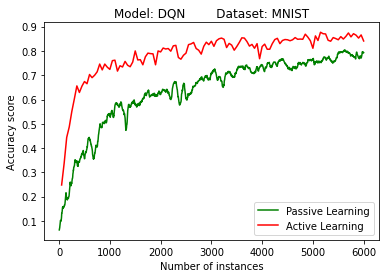

In [16]:
x1 = [item[0] for item in D1]
y1 = [item[1] for item in D1]
x2 = [item[0] for item in D2]
y2 = [item[1] for item in D2]
plt.plot(x1, y1, c='green', label='Passive Learning')
plt.plot(x2, y2, c='red', label='Active Learning')
plt.title('Model: DQN        Dataset: MNIST')
plt.xlabel('Number of instances')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()